# Installation, Import, Mount

In [ ]:
!pip install entsoe-py
!pip install retry
!pip install spektral
!pip install livelossplot
!pip install geoplot

In [2]:
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area

from retry import retry
from datetime import timedelta
from itertools import product

import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, ConvLSTM2D, Bidirectional, MaxPooling2D, MaxPooling3D
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from livelossplot import PlotLossesKeras

from spektral.data import Graph, Dataset, BatchLoader
from spektral.transforms import GCNFilter
from spektral.layers import GCNConv, ECCConv, GlobalSumPool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, box

import math

import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# implementierte Methoden

## Datenaufbereitung

In [ ]:
def wind_spddir_to_uv(wspd,wdir): 
    """
    Methode von Max Kämmerling

    berechnet u und v Windkomponenten aus Windgeschwindigkeit und -richtung
    Input:
        wspd: Windgeschwindigkeit
        wdir: Windrichtung
    Output:
        u = West-Ost-Komponente in [m/s] (Wind aus dem Westen ist positiv, aus dem Osten negativ)
        v = Nord-Süd_komponente in [m/s] (Wind aus dem Süden ist positiv, aus dem Norden negativ)
    """   
    rad = np.pi/180. # = pi/180 (für die Umrechnung von Grad zu Radianten)
    u = -wspd*np.sin(rad*wdir)
    v = -wspd*np.cos(rad*wdir)
    return u,v

In [ ]:
@retry(tries=3, delay=1)  #Falls Verbindung abbricht wird eine Sekunde gewartet und nochmal versucht. Bis zu 3 Versuche insgesamt.
def read_p_obs(biddingZone, nameShort, psr_type, start_year, end_year, start_month, end_month):
  code = lookup_area(biddingZone) #Code für client query
  
  #Auslesen der Zeitreihen aller on-/offshore Windparks in dieser bidding Zone
  generation = client.query_generation_per_plant(country_code=code, start=pd.Timestamp(pd.to_datetime('20'+str(start_year)+'{0:02d}'.format(start_month)+'010000'), tz='UTC'), end=pd.Timestamp(pd.to_datetime('20'+str(end_year)+'{0:02d}'.format(end_month)+'010000'), tz='UTC'), psr_type=psr_type)
  generation['DateTime'] = generation.index.tz_convert('UTC') #UTC Zeitstempel, da Wetterdaten auch in diesem Zeitformat
  generation.set_index(['DateTime'], inplace=True)

  return generation

## Erstellen der Datensätze

In [ ]:
def get_input_output_data(genUnitEIC, rea_model, time_component):

  if time_component:  #mit Zeitkomponente wird die interpolierte Zeitreihe geladen
    data_in_out = pd.read_hdf('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/' + rea_model + '/' + genUnitEIC + '_MVimputed.h5')
  else:
    data_in_out = pd.read_hdf('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/' + rea_model + '/' + genUnitEIC + '_MVdeleted.h5')
 
  return data_in_out

In [ ]:
#Data Split für Spektral Graphdatensätze
def train_test_split_graphdata(dataset, training_prop):
  return dataset[:int(training_prop*dataset.n_graphs)], dataset[int(training_prop*dataset.n_graphs):] 

In [ ]:
def fill_grid(data, pos_arr, rea_model, turbine_list):
  if rea_model == 'all_rea_sets_combined':                                #erzeuge Array in Form des Gitters
    X = np.zeros(shape=(len(data),pos_arr.shape[0],pos_arr.shape[1],8)) 
  else:
    X = np.zeros(shape=(len(data),pos_arr.shape[0],pos_arr.shape[1],4))
  for i in range(pos_arr.shape[0]):       
    for j in range(pos_arr.shape[1]):
      if pos_arr[i,j] != 0:                                               #falls sich ein Windrad in dieser Zelle befindet
        turbine = turbine_list[pos_arr[i,j]-1]                            #bestimme Windradnummer
        X[:,i,j,:] = data.loc[:,turbine]                                  #fülle diese Zelle mit Zeitreihe dieses Windrads
  return X

In [ ]:
# Erstellen eines ECC Graphdatensatzes

class ECCDataset(Dataset):

  def __init__(self, data, adjacency_matrix, distance_matrix_dir, parameters, rea_model, **kwargs):
    self.data = data
    self.adjacency_matrix = adjacency_matrix
    self.distance_matrix_dir = distance_matrix_dir
    self.n_turbines = len(adjacency_matrix)
    self.parameters = parameters
    self.rea_model = rea_model
    if rea_model == 'all_rea_sets_combined':
      self.dim_node_features = len(parameters)*2  #doppelte Parameter
    else:
      self.dim_node_features = len(parameters)
    self.dim_edge_features = 2 
    super().__init__(**kwargs)

  def read(self):
    g = []        #Liste von Graphen

    turbine_list = []             #Windradliste
    for i in self.data.columns:
      turbine_list.append(i[0])
    turbine_list = list(dict.fromkeys(turbine_list[:-1]))

    if self.rea_model == 'all_rea_sets_combined': #doppelte Parameter mit cosmo und era Endung
      parameter_list = []
      for parameter in self.parameters:
        parameter_list.append(parameter + '_cosmo')
        parameter_list.append(parameter + '_era')

    printcounter = 0

    for i in self.data.index:                                                   # für jeden Zeitschritt
      x = np.zeros((self.n_turbines,self.dim_node_features))                    # leere Knotenattributsmatrix
      e = np.zeros((self.n_turbines, self.n_turbines, self.dim_edge_features))  # leere Kantenattributsmatrix
      y = self.data.loc[i,('p_obs','')]                                         # Graphlabel

      for j in range(self.n_turbines):                                            #für jedes Windrad
        turbine = turbine_list[j]

        for k in range(self.dim_node_features):                                      #für jeden Parameter

          if self.rea_model == 'all_rea_sets_combined':
            parameter = parameter_list[k]
          else:
            parameter = self.parameters[k]

          x[j,k] = self.data.loc[i,(turbine,parameter)]                              #Knotenattributsvektor

        for l in range(self.n_turbines):                                             #für jedes Windrad
          if self.adjacency_matrix[j,l] == 1:                                        #falls Windrad benachbart
            e[j,l,0] = self.distance_matrix_dir[j,l,0]                               #Kantenattributsvektor mit vektorieller Entfernung
            e[j,l,1] = self.distance_matrix_dir[j,l,1]
            
      printcounter +=1                                                          #jeden tausendsten Zeitschritt Fortschritt ausgeben
      if printcounter == 1000:
        print(i)
        printcounter = 0

      gr = Graph(x=x, a=self.adjacency_matrix, e=e, y=y)                          #Graph erzeugen
      g.append(gr)                                                                #Graph zu Liste hinzufügen

    return g

In [ ]:
# Erstellen eines GCN Graphdatensatzes

class GCNConvDataset(Dataset):

  def __init__(self, data, adjacency_matrix, distance_matrix_dir, coordinates, parameters, rea_model, **kwargs):
        self.data = data
        self.adjacency_matrix = adjacency_matrix
        self.distance_matrix_dir = distance_matrix_dir
        self.coordinates = coordinates
        self.n_turbines = len(adjacency_matrix)
        self.parameters = parameters
        self.rea_model = rea_model
        if rea_model == 'all_rea_sets_combined':
          self.dim_node_features = len(parameters)*2 + 2  #doppelte Parameter + 2 Koordinaten
        else:
          self.dim_node_features = len(parameters) + 2
        super().__init__(**kwargs)

  def read(self):
    g = []              #Liste von Graphen

    turbine_list = []             #Windradliste
    for i in self.data.columns:
      turbine_list.append(i[0])
    turbine_list = list(dict.fromkeys(turbine_list[:-1]))

    if self.rea_model == 'all_rea_sets_combined':         #doppelte Parameter mit cosmo und era Endung
      parameter_list = []
      for parameter in self.parameters:
        parameter_list.append(parameter + '_cosmo')
        parameter_list.append(parameter + '_era')

    printcounter = 0

    for i in self.data.index:                                 # für jeden Zeitschritt
      x = np.zeros((self.n_turbines,self.dim_node_features))  # leere Knotenattributsmatrix
      y = self.data.loc[i,('p_obs','')]                       # Graphlabel

      for j in range(self.n_turbines):                          #für jedes Windrad
        turbine = turbine_list[j]

        for k in range(self.dim_node_features-2):                 #für jeden Parameter
          if self.rea_model == 'all_rea_sets_combined':
            parameter = parameter_list[k]
          else:
            parameter = self.parameters[k]
          
          x[j,k] = self.data.loc[i,(turbine,parameter)]           #Knotenattributsvektor aus Parametern und Koordinaten

        x[j,k+1] = self.coordinates.iloc[j,0]
        x[j,k+2] = self.coordinates.iloc[j,1]
        
      gr = Graph(x=x, a=self.adjacency_matrix, y=y)             #Graph erzeugen
      g.append(gr)                                              #Graph zu Liste hinzufügen

      printcounter +=1                                             #jeden tausendsten Zeitschritt Fortschritt ausgeben
      if printcounter == 1000:
        print(i)
        printcounter = 0

    return g

In [ ]:
def get_datasets_loaders(genUnitEIC, parktype, model_architecture, parameters, rea_model, test_split):
  '''
  Gibt Testdatensatz, Spektral Loader und benötigte Zeit für ECC- und GCN-Architektur zurück
  '''
  coordinates = get_turbine_coordinates(genUnitEIC, parktype)
  distance_matrix, distance_matrix_dir = compute_distance_matrix(coordinates)

  if model_architecture == 'ECC':
    adjacency_matrix = compute_adjacency_matrix(genUnitEIC, distance_matrix, park_metadata, 10)
    start = time.perf_counter()
    dataset = ECCDataset(data, adjacency_matrix, distance_matrix_dir, parameters, rea_model)
    end = time.perf_counter()
    time_spektral = end - start
    
  else:
    adjacency_matrix = compute_adjacency_matrix(genUnitEIC, distance_matrix, park_metadata, 8)
    start = time.perf_counter()
    dataset = GCNConvDataset(data, adjacency_matrix, distance_matrix_dir, coordinates, parameters, rea_model)
    dataset.apply(GCNFilter())
    end = time.perf_counter()
    time_spektral = end - start

  # unterteile Datensätze
  dataset_tr, dataset_test = train_test_split_graphdata(dataset, (1-test_split))
  dataset_train, dataset_val = train_test_split_graphdata(dataset_tr, (1-test_split))

  # Erzeuge Loader
  loader_train = BatchLoader(dataset_train, batch_size=32, shuffle=False)
  loader_val = BatchLoader(dataset_val, batch_size=32, shuffle=False)
  loader_test = BatchLoader(dataset_test, batch_size=32, shuffle=False)

  return time_spektral, dataset_test, loader_train, loader_val, loader_test

In [ ]:
# Erstellen eines ECC Graphdatensatzes ohne topologische Information

class ECCDataset_WithoutTopology(Dataset):

  def __init__(self, data, parameters, rea_model, **kwargs):
    self.data = data
    self.parameters = parameters
    self.rea_model = rea_model
    if rea_model == 'all_rea_sets_combined':
      self.dim_node_features = len(parameters)*2 
    else:
      self.dim_node_features = len(parameters)
    self.dim_edge_features = 2 
    super().__init__(**kwargs)

  def read(self):
    g = []

    turbine_list = []
    for i in self.data.columns:
      turbine_list.append(i[0])
    turbine_list = list(dict.fromkeys(turbine_list[:-1]))

    if self.rea_model == 'all_rea_sets_combined':
      parameter_list = []
      for parameter in self.parameters:
        parameter_list.append(parameter + '_cosmo')
        parameter_list.append(parameter + '_era')

    printcounter = 0

    for i in self.data.index:
      x = np.zeros((1, self.dim_node_features)) #nur ein Knoten
      e = np.zeros((1, 1, 1))                     
      a = np.ones(shape=(1,1))
      y = self.data.loc[i,('p_obs','')]

      for k in range(self.dim_node_features):

        if self.rea_model == 'all_rea_sets_combined':
          parameter = parameter_list[k]
        else:
          parameter = self.parameters[k]

        x[0,k] = self.data.loc[i,(turbine_list,parameter)].mean() #Durchschnittlicheer Attributsvektor aller Windräder 
            
      printcounter +=1
      if printcounter == 1000:
        print(i)
        printcounter = 0

      gr = Graph(x=x, a=a, e=e, y=y)
      g.append(gr)

    return g

In [ ]:
# Erstellen eines GCN Graphdatensatzes ohne topologische Information

class GCNConvDataset_WithoutTopology(Dataset):

  def __init__(self, data, coordinates, parameters, rea_model, **kwargs):
        self.data = data
        self.coordinates = coordinates
        self.parameters = parameters
        self.rea_model = rea_model
        if rea_model == 'all_rea_sets_combined':
          self.dim_node_features = len(parameters)*2 + 2 
        else:
          self.dim_node_features = len(parameters) + 2
        super().__init__(**kwargs)

  def read(self):
    g = []

    turbine_list = []
    for i in self.data.columns:
      turbine_list.append(i[0])
    turbine_list = list(dict.fromkeys(turbine_list[:-1]))

    if self.rea_model == 'all_rea_sets_combined':
      parameter_list = []
      for parameter in self.parameters:
        parameter_list.append(parameter + '_cosmo')
        parameter_list.append(parameter + '_era')

    printcounter = 0

    for i in self.data.index:
      x = np.zeros((1,self.dim_node_features))    #nur ein Knoten
      a = np.ones(shape=(1,1))
      y = self.data.loc[i,('p_obs','')]

      for k in range(self.dim_node_features-2):
        if self.rea_model == 'all_rea_sets_combined':
          parameter = parameter_list[k]
        else:
          parameter = self.parameters[k]
        
        x[0,k] = self.data.loc[i,(turbine_list,parameter)].mean() #Durchschnittlicheer Attributsvektor aller Windräder 

        x[0,k+1] = self.coordinates.iloc[0,0]                     #Koordinaten des ersten Windrads
        x[0,k+2] = self.coordinates.iloc[0,1]
        
      gr = Graph(x=x, a=a, y=y)
      g.append(gr)

      printcounter +=1
      if printcounter == 1000:
        print(i)
        printcounter = 0

    return g

In [ ]:
#Beobachtungszeitreihe (Graphlabel) aus Spektraldatensatz
def actual(dataset):
  actual= []
  for i in range(len(dataset)):
    actual.append(dataset[i].y)
  return actual

## Topologische Struktur

In [ ]:
def get_turbine_coordinates(genUnitEIC , parktype):

  
  turbine_metadata = pd.read_csv('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/allEIC_Era5_2015_2020/model_output_' + parktype + '_turbineinfo.csv')
  
  for i in turbine_metadata.index:  #Lösche ' am Ende des EIC-Strings
    park = turbine_metadata.at[i, 'GenUnitEIC'][:-1] 
    turbine_metadata.loc[i, 'GenUnitEIC'] = park
  
  turbine_coordinates = turbine_metadata.loc[turbine_metadata['GenUnitEIC'] == genUnitEIC, 'lat':'lon']
  turbine_coordinates.reset_index(drop=True,inplace=True)

  return turbine_coordinates

In [ ]:
def compute_distance_matrix(coordinates):
  distance_matrix = np.zeros((len(coordinates),len(coordinates)))       #leere Distanzmatrix in Form (n_turbine x n_turbine)
  distance_matrix_dir = np.zeros((len(coordinates),len(coordinates),2)) #Distanz in Ost-West Richtung und Nord-Süd Richtung (nach Nord-Ost ist positiv, Süd-West ist negativ), Form (n_turbine x n_turbine x 2)


  for i in range(len(coordinates)):
    for j in range(len(coordinates)):
      
      distance_matrix[i,j] = geodesic((coordinates.loc[i,'lat'],coordinates.loc[i,'lon']), (coordinates.loc[j,'lat'],coordinates.loc[j,'lon'])).kilometers #Abstand der beiden WKA
      
      if coordinates.loc[i,'lat'] <= coordinates.loc[j,'lat']: #falls i westlich von j ist Abstand positiv
        distance_matrix_dir[i,j,0] = geodesic((coordinates.loc[i,'lat'],coordinates.loc[i,'lon']),(coordinates.loc[j,'lat'],coordinates.loc[i,'lon'])).kilometers #Abstand in Ost-West Richtung
      else:
        distance_matrix_dir[i,j,0] = - geodesic((coordinates.loc[i,'lat'],coordinates.loc[i,'lon']),(coordinates.loc[j,'lat'],coordinates.loc[i,'lon'])).kilometers

      if coordinates.loc[i,'lon'] <= coordinates.loc[j,'lon']: #falls i südlich von j ist Abstand positiv
        distance_matrix_dir[i,j,1] = geodesic((coordinates.loc[i,'lat'],coordinates.loc[i,'lon']),(coordinates.loc[i,'lat'],coordinates.loc[j,'lon'])).kilometers #Abstand in Nord-Süd Richtung
      else:
        distance_matrix_dir[i,j,1] = - geodesic((coordinates.loc[i,'lat'],coordinates.loc[i,'lon']),(coordinates.loc[i,'lat'],coordinates.loc[j,'lon'])).kilometers

  return distance_matrix, distance_matrix_dir

In [ ]:
def compute_adjacency_matrix(genUnitEIC, distance_matrix, park_metadata ,factor):

  adjacency_matrix = np.zeros(shape=(len(distance_matrix),len(distance_matrix)))    # mit Nullen gefüllte Matrix der Form (n_turbine x n_turbine)
  rotor_diameter = park_metadata.loc[genUnitEIC, 'rotorDiameter'] / 1000            # Rotordurchmesser in km

  #Klassiere Windräder als Nachbarn, falls  sie näher als Rotordurchmesser * Skalierungsfaktor sind
  for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
      if distance_matrix[i,j] < rotor_diameter*factor and i != j:
        adjacency_matrix[i,j] = 1

  #Informationen über Graph
  n_neighbor_avg = adjacency_matrix.sum(axis=0).mean()
  n_nodes = len(distance_matrix)
  n_edges = int(adjacency_matrix.sum() / 2)
  print('durchschnittliche Anzahl an Nachbarn: {:0.2f}'.format(n_neighbor_avg))
  print('Anzahl Knoten: ' + str(n_nodes))
  print('Anzahl Kanten: ' + str(n_edges))
  print('\n')

  return adjacency_matrix

In [ ]:
def visualizeGraph(coordinates, adjacency_matrix):
  turbine_points = coordinates.apply(lambda srs: Point(float(srs['lon']), float(srs['lat'])),
    axis='columns')
  df_geocoded = gpd.GeoDataFrame(geometry=turbine_points) #Geopandas Dataframe mit Windradkoordinaten als Punkte

  edges_linestrings = [] #Liste mit Verbindungen zwischen Windrädern
  for i in range(len(coordinates)):
    for j in range(len(coordinates)):
      if adjacency_matrix[i,j] == 1:
        edges_linestrings.append(LineString([turbine_points[i], turbine_points[j]])) 
  edges = gpd.GeoDataFrame(geometry=edges_linestrings) #Geopandas Dataframe mit Kanten als Linestrings

  #plotten
  fig, ax = plt.subplots(figsize=(15,15))

  df_geocoded.plot(ax=ax, aspect=1.5, markersize=130)
  edges.plot(ax=ax, aspect=1.5, linewidth=4)
  ax.axis('off')
  
  return plt.show()

In [ ]:
def create_grid(coordinates):
  turbine_points = coordinates.apply(lambda srs: Point(float(srs['lon']), float(srs['lat'])),axis='columns') #erstelle shapely Punkte aus Koordinaten
  gdf = gpd.GeoDataFrame(geometry=turbine_points) #Geopandas Dataframe mit Koordinaten als Punkte

  xmin, ymin, xmax, ymax= gdf.total_bounds  #Maxima und Minima der Längen- und Breitengrade
  counter = 0
  n_cells=0
  while counter < (len(coordinates)-1): #while mehr als ein Windrad in einer Zelle
    #Anzahl Zellen in längerer Richtung
    n_cells += 1
    #Größe der Zellen: Längere Richtung / Anzahl Zellen aufgerundet auf 5 Nachkommastellen, damit auch das letzte Windrad im Gitter ist
    cell_size = round_decimals_up((np.max([xmax-xmin, ymax-ymin]))/n_cells, 5)
    #Erzeuge die Zellen in einer Schleife
    grid_cells = [] #Liste der Zellen
    l = []          #Liste mit Windradpositionen
    x=0             #Anzahl Zellen in x-Richtung
    y=0             #Anzahl Zellen in y-Richtung 
    for y0 in np.arange(ymax, ymin, -cell_size):    #von oben nach unten mit der Schrittgröße cell_size
      x=0
      for x0 in np.arange(xmin, xmax, cell_size ):  #von links nach rechts mit der Schrittgröße cell_size
        #rechte und untere Grenze der Zelle
        x1 = x0+cell_size
        y1 = y0-cell_size
        grid_cells.append(box(x0, y0, x1, y1))      #Zelle wird als shapely Box erzeugt und Liste hinzugefügt

        counter = 0
        for t in coordinates.index:
          if (x0 <= coordinates.loc[t,'lon'] <= x1) and (y1 <= coordinates.loc[t,'lat'] <= y0):
            l.append(t+1)   #falls das Windrad sich in der Zelle befindet, wird die Windradnummer der Liste angehängt
          else:
            counter += 1

        if counter == len(coordinates):       #falls sich kein Windrad in der Zelle befindet wird eine 0 angehängt
          l.append(0)
        elif counter < (len(coordinates)-1):  #falls sich mehr als ein Windrad in der Zelle befindet wird innere Schleife unterbrochen
          break
        
        x += 1
      y += 1
      
      if counter < (len(coordinates)-1):      #falls sich mehr als ein Windrad in der Zelle befindet wird auch äußere Schleife unterbrochen
        break                                 #while-Schleife wird erneut durchlaufen mit n_cells + 1

  cell = gpd.GeoDataFrame(grid_cells, columns=['geometry']) #GeoDataFrame wird aus Zellen erschaffen
  pos_arr = np.array(l).reshape((y,x))                      #aus l wird ein Array mit Dimension (y,x)

  return cell, pos_arr

## Modelle

In [ ]:
class ECC(Model):

    def __init__(self, n_hidden):
        super().__init__()
        self.graph_conv = ECCConv(n_hidden, activation='sigmoid')
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(16,'sigmoid')
        self.dense1 = Dense(1, 'sigmoid') 

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)
        out = self.dense1(out)

        return out

In [ ]:
class GCN(Model):

    def __init__(self, n_hidden):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden, activation='sigmoid')
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(16,'sigmoid')
        self.dense1 = Dense(1, 'sigmoid') 

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)
        out = self.dense1(out)

        return out

In [ ]:
def create_model(model_architecture, optimizer, X_train=0):
'''
Aufbau der Modelle und entsprechender Eingabedaten ist sehr detailliert in der BA beschrieben
'''
  if model_architecture == 'ECC':
    model = ECC(8)

  elif model_architecture == 'GCN':
    model = GCN(8)

  elif model_architecture == 'CNN':
    model = Sequential()
    model.add(Conv2D(filters=8, 
                     kernel_size=5, 
                     padding='same', 
                     activation='sigmoid', 
                     input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])
                     ))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16,'sigmoid'))
    model.add(Dense(1, activation='sigmoid')) 

  elif model_architecture == 'ConvLSTM':
    model = Sequential()
    model.add(ConvLSTM2D(filters=8, 
                         kernel_size=5, 
                         padding='same',
                         return_sequences = True, 
                         activation='sigmoid', 
                         input_shape=(1, X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                         data_format='channels_last'))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16,'sigmoid'))
    model.add(Dense(1, activation='sigmoid')) 

  elif model_architecture == 'BidirConvLSTM':
    model = Sequential()
    model.add(Bidirectional(
        ConvLSTM2D(filters=8, 
                   kernel_size=5, 
                   padding='same', 
                   return_sequences = True, 
                   activation='sigmoid', 
                   input_shape=(1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16,'sigmoid'))
    model.add(Dense(1, activation='sigmoid')) 

  #Modell kompilieren
  model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

  return model

## Andere

In [ ]:
def shift(arr, num, fill_value=np.nan):
  '''
  nötig für plotten der gesamten Testzeitreihe in zwei verschiedenen Figures
  '''
  result = np.empty((len(arr)+num,1))
  if num > 0:
      result[:num] = fill_value
      result[num:] = arr
  elif num < 0:
      result[num:] = fill_value
      result[:num] = arr
  else:
      result[:] = arr
  return result

In [ ]:
class TrainingTimeCallback(Callback):
  """
  Methode von Max Kämmerling
  
  TrainingTimeCallback misst die Zeit, die für das Training benötigt wird.
  """
  def __init__(self):
    self.starttime=0
    self.training_time=0

  def on_train_begin(self, epoch, logs={}):
    self.starttime= time.time()
  def on_train_end(self, epoch, logs={}):
    self.training_time += (time.time()-self.starttime)

In [ ]:
def round_decimals_up(number:float, decimals:int=2):
    """
    Gibt einen Wert zurück, der zu einer bestimmten Anzahl von Dezimalstellen aufgerundet wurde
    """
    if not isinstance(decimals, int):
        raise TypeError("Anzahl Dezimalstellen muss ein int Wert sein")
    elif decimals < 0:
        raise ValueError("Anzahl Dezimalstellen muss 0 oder mehr sein")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [ ]:
def get_p_model_test(data, rea_model, test_split):
  if rea_model == 'all_rea_sets_combined':
    #durchschnittliche kombinierte Vorhersage der beiden Modelle
    p_model = pd.concat([data.loc[:,(turbine_list,'p_model_cosmo')], 
                         data.loc[:,(turbine_list,'p_model_era')]], axis=1).mean(axis=1) 
  else:
    p_model = data.loc[:,(turbine_list,'p_model')].mean(axis=1)

  p_model_test = p_model[int(len(p_model)*(1-test_split)):]
  p_model_test.reset_index(drop=True, inplace=True)

  return p_model_test

# Datenaufbereitung

## Erstellen von Park Metadata

In [ ]:
#------------------------onshore park metadata------------------------#
turbine_metadata_onshore = pd.read_csv('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/allEIC_CosmoRea6_2015_2018/model_output_onshore_turbineinfo.csv')
#aus turbine_metadata_onshore wurden die Parks ohne topologische Information (Berry Burn, Mid Hill, Harestanes, Cairn Uish 2, Tullo Extension) manuell gelöscht 
#Parks die nur aus einzelnen Windräder bestehen wurden gelöscht (Utsira vind, SOLVIND ÅSEN AS, STORØY VINDPARK AS)
#und bei einigen Parks die fehlerhaften Windräder gelöscht (Fallago Rig(12), Clyde Central(38), Arecleoch(23), Toddleburn(2), Goole Fields(2))

#lösche Anführungszeichen am Ende der Strings
for i in range(len(turbine_metadata_onshore)):

  park = turbine_metadata_onshore.at[i, 'GenUnitEIC'][0:-1]
  turbine_metadata_onshore.loc[i, 'GenUnitEIC'] = park

  country = turbine_metadata_onshore.at[i, 'countryCode'][0:-1]
  turbine_metadata_onshore.loc[i, 'countryCode'] = country

  name_long = turbine_metadata_onshore.at[i, 'nameLong'][0:-1]
  turbine_metadata_onshore.loc[i, 'nameLong'] = name_long

  nameShort = turbine_metadata_onshore.at[i, 'nameShort'][0:-1]
  turbine_metadata_onshore.loc[i, 'nameShort'] = nameShort

#lösche nicht mehr nutzbare Parks
turbine_metadata_onshore.drop(turbine_metadata_onshore[turbine_metadata_onshore['nameShort']=='RWE'].index, inplace=True)

#lösche Parks die nur aus einzelnen Windräder bestehen (Utsira vind, SOLVIND ÅSEN AS, STORØY VINDPARK AS)
drop_single_list = ['Utsira vind - og hydrogenanlegg_Solvind Prosjekt AS_200', 'SOLVIND ÅSEN AS_Solvind Prosjekt AS_201', 'STORØY VINDPARK AS_Solvind Prosjekt AS_202']
turbine_metadata_onshore = turbine_metadata_onshore[~turbine_metadata_onshore['GenUnitEIC'].isin(drop_single_list)]

turbine_metadata_onshore.reset_index(drop=True, inplace=True)

#erstelle parks_metadata_onshore aus relevanten Spalten
parks_metadata_onshore = turbine_metadata_onshore[['GenUnitEIC', 'countryID', 'countryCode', 'nameLong',  'nameShort', 'lat', 'lon', 'cut_in', 'cut_out']]  #relevante Spalten
parks_metadata_onshore.drop_duplicates(subset='GenUnitEIC', keep='first', inplace=True) #pro Park nur erstes Windrad als Repräsentant betrachten
parks_metadata_onshore['on-/offshore'] = 'onshore'  #on-/offshore Spalte
parks_metadata_onshore.set_index(['GenUnitEIC'], inplace=True) #setze GenUnitEIC als Index

#summiere einzelne Kapazitäten der Windräder zu Gesamtkapazität des Parks
parks_metadata_onshore['totalCap']= 0.0
for i in turbine_metadata_onshore.index:
  park = turbine_metadata_onshore['GenUnitEIC'].get(i)
  cap = turbine_metadata_onshore['cap'].get(i)
  parks_metadata_onshore.loc[park,'totalCap'] += cap

#Korrekturen für Parks mit teilweise entfernten Windrädern (siehe oben)
parks_metadata_onshore['installedCap'] = parks_metadata_onshore['totalCap']
parks_metadata_onshore.loc['48W00000FALGW-1T','installedCap'] += 12*3000  #Fallago Rig
parks_metadata_onshore.loc['48W00000CLDCW-17','installedCap'] += 38*2300  #Clyde Central
parks_metadata_onshore.loc['48W10000ARCHW-1N','installedCap'] += 23*2000  #Arecleoch
parks_metadata_onshore.loc['48W00000TDBNW-1W','installedCap'] += 2*2300   #Toddleburn
parks_metadata_onshore.loc['48W00000GFLDW-11','installedCap'] += 2*2050   #Goole Fields

#Korrekturen für Parks, bei denen Kapazität der ENTSO-E Erzeugungszeitreihe nicht mit summierter Kapazität der Reanalysemodelle
#übereinstimmt. In den meisten Fällen, da nur ein Teil des Parks in dem Reanalysemodell erfasst ist.
#manuell in Exceldatei verbessert und farblich markiert

#------------------------offshore park metadata------------------------#
turbine_metadata_offshore = pd.read_csv('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/allEIC_CosmoRea6_2015_2018/model_output_offshore_turbineinfo.csv')

#lösche Parks ohne topologische Information
droplist=[]
for i in range(len(turbine_metadata_offshore)-1):
  if turbine_metadata_offshore.loc[i,'lat'] == turbine_metadata_offshore.loc[i+1,'lat']:
    droplist.append(turbine_metadata_offshore.loc[i,'GenUnitEIC'])
droplist = list(dict.fromkeys(droplist))
turbine_metadata_offshore = turbine_metadata_offshore[~turbine_metadata_offshore['GenUnitEIC'].isin(droplist)]

turbine_metadata_offshore.reset_index(drop=True, inplace=True)

#lösche Anführungszeichen am Ende der Strings
for i in range(len(turbine_metadata_offshore)):

  park = turbine_metadata_offshore.at[i, 'GenUnitEIC'][0:-1]
  turbine_metadata_offshore.loc[i, 'GenUnitEIC'] = park

  country = turbine_metadata_offshore.at[i, 'countryCode'][0:-1]
  turbine_metadata_offshore.loc[i, 'countryCode'] = country

  name_long = turbine_metadata_offshore.at[i, 'nameLong'][0:-1]
  turbine_metadata_offshore.loc[i, 'nameLong'] = name_long

  nameShort = turbine_metadata_offshore.at[i, 'nameShort'][0:-1]
  turbine_metadata_offshore.loc[i, 'nameShort'] = nameShort

#lösche nicht mehr nutzbare Parks
turbine_metadata_offshore.drop(turbine_metadata_offshore[turbine_metadata_offshore['nameShort']=='RWE'].index, inplace=True)
turbine_metadata_offshore.reset_index(drop=True, inplace=True)

#erstelle parks_metadata_offshore aus relevanten Spalten
parks_metadata_offshore = turbine_metadata_offshore[['GenUnitEIC', 'countryID', 'countryCode', 'nameLong',  'nameShort', 'lat', 'lon', 'cut_in', 'cut_out']]
parks_metadata_offshore.drop_duplicates(subset='GenUnitEIC', keep='first', inplace=True)
parks_metadata_offshore['on-/offshore'] = 'offshore'
parks_metadata_offshore.set_index(['GenUnitEIC'], inplace=True)

#summiere einzelne Kapazitäten der Windräder zu Gesamtkapazität des Parks
parks_metadata_offshore['totalCap']= 0.0
for i in turbine_metadata_offshore.index:
  park = turbine_metadata_offshore['GenUnitEIC'].get(i)
  cap = turbine_metadata_offshore['cap'].get(i)
  parks_metadata_offshore.loc[park,'totalCap'] += cap

parks_metadata_offshore['installedCap'] = parks_metadata_offshore['totalCap']

#Korrekturen für Parks, bei denen Kapazität der ENTSO-E Erzeugungszeitreihe nicht mit summierter Kapazität der Reanalysemodelle
#übereinstimmt. In den meisten Fällen, da nur ein Teil des Parks in dem Reanalysemodell erfasst ist.
#manuell in Exceldatei verbessert und farblich markiert

#------combine on- and offshore metadata-----#
parks_metadata = pd.concat([parks_metadata_onshore, parks_metadata_offshore])

#add index
id_series = pd.Series(range(1, len(parks_metadata)+1))
parks_metadata.insert(0, 'ID', id_series.values)

#Abspeichern | turbineModel, rotorDiameter und hubHeight wurden manuell recherchiert und zu parks_metadata hinzugefügt
#with pd.ExcelWriter("/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/park_metadata.xlsx") as writer:
#    parks_metadata.to_excel(writer)

## Auslesen der Erzeugungszeitreihen von ENTSO-E Transparency

In [ ]:
#Konstanten
p_obs_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/observation data/observation time series/'
park_metadata = pd.read_excel('/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx', index_col=0)

client = EntsoePandasClient(api_key='e5330187-fab9-46a8-bd37-6a8f39fdf8a8')

Das Auslesen der Erzeugungszeitreihen wurde aufgrund von Verbindungsproblemen und der langen Laufzeit getrennt für verschiedene Biddingzones und Parktypen gemacht. 
Die Funktion read_p_obs() gibt hierbei die Erzeugungszeitreihen von allen Parks, dieses Parktyps, in dieser Biddingzones als Dataframe zurück.

In [ ]:
#-----Auslesen für die 4 dänischen Parks-----------# (etwa 1,5h Laufzeit)

biddingZone = 'DK_CA'
nameShort = ['Anholt', 'Horns Rev A', 'Roedsand 1', 'Roedsand 2']
psr_type='B18'  #offshore wind

generation_park = pd.DataFrame()

if psr_type == 'B19':
  column_name = 'Wind Onshore'
else:
  column_name = 'Wind Offshore'

for year in range(15,21):   #iteriert über alle Jahre
  for month in range(1,13): #und Monate                 muss monatlich abgerufen werden, da es bei längeren Zeiträumen immer häufiger zu Verbindungsabbrüchen kommt (unmöglich fü 6 Jahre auf einmal)
    print('20'+str(year) + '/' + '{0:02d}'.format(month)) #YYYY/MM

    try:
      if month != 12:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year, start_month=month, end_month=month+1)
        generation.drop(columns=('Horns Rev B', 'Wind Offshore'), inplace=True) #nicht relevanter Park
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)  #nötig, da sonst die Zeilen mit NaN-Werten einfach verschwinden
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)  #umbenennen der Spaltennamen. Bsp.: (Anholt, Wind Offshore) -> Anholt
        generation_park = generation_park.append(df)
      else:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year+1, start_month=month, end_month=1) #falls month=12 ist Endzeitpunkt der Januar des nächsten Jahres
        generation.drop(columns=('Horns Rev B', 'Wind Offshore'), inplace=True)
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)
        generation_park = generation_park.append(df)

    except Exception: #tritt auf, falls für gesamten Monat für alle Windparks keine Daten vorliegen
      print('Problem mit Monat 20'+str(year) + '/' + '{0:02d}'.format(month))
      if month != 12:
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df[nameShort] = np.nan
        generation_park = generation_park.append(df)  #Dataframe wird manuell um diesen Monat verlängert mit NaN-Werten
      else:
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df[nameShort] = np.nan
        generation_park = generation_park.append(df) 

for park in nameShort:  #Zeitreihen abspeichern
  genUnitEIC = park_metadata[park_metadata['nameShort']==park].index[0]
  # generation_park[park].rename('p_obs').to_csv(p_obs_path + genUnitEIC + '.csv')

In [ ]:
#-----Auslesen für die 5 britischen offshore Parks-----------# (etwa 8h Laufzeit)

biddingZone = 'GB'
nameShort = ['GNFSW-1', 'GNFSW-2', 'GRGBW-1', 'GRGBW-2', 'LARYO-1', 'LARYO-2', 'LARYO-3', 'LARYO-4']
psr_type='B18'  #offshore wind

generation_park = pd.DataFrame()

if psr_type == 'B19':
  column_name = 'Wind Onshore'
else:
  column_name = 'Wind Offshore'

for year in range(15,21):                                 #iteriert über alle Jahre
  for month in range(1,13):                               #und Monate
    print('20'+str(year) + '/' + '{0:02d}'.format(month)) #YYYY/MM

    try:
      if month != 12:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year, start_month=month, end_month=month+1)
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)                                                        #nötig, da sonst die Zeilen mit NaN-Werten einfach verschwinden
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)  #umbenennen der Spaltennamen
        generation_park = generation_park.append(df)
      else:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year+1, start_month=month, end_month=1) #falls month=12 ist Endzeitpunkt der Januar des nächsten Jahres
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)
        generation_park = generation_park.append(df)

    except Exception:                                                            #Tritt auf, falls für gesamten Monat keine Daten vorliegen.
      print('Problem mit Monat 20'+str(year) + '/' + '{0:02d}'.format(month))
      if month != 12:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df)                             #Dataframe wird manuell um diesen Monat verlängert mit NaN-Werten
      else:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df) 

    # generation_park.to_csv(p_obs_path + 'Zwischenergebnis_GB_offshore.csv')         #Zwischenergebnis abspeichern

for park in nameShort[0:4]:                                                           #Zeitreihen abspeichern
  genUnitEIC = park_metadata[park_metadata['nameShort']==park].index[0]
  # generation_park[park].rename('p_obs').to_csv(p_obs_path + genUnitEIC + '.csv')

# Extrabehandlung von London Array, da die Zeitreihen für die vier Teile getrennt vorliegen
df = pd.DataFrame(index=generation_park[park].index)
df['p_obs'] = generation_park['LARYO-1'] + generation_park['LARYO-2'] + generation_park['LARYO-3'] + generation_park['LARYO-4']
# df.to_csv(p_obs_path + '48W00000LARYO-1Z' + '.csv')

In [ ]:
#-----Auslesen für die 25 britischen onshore Parks-----------# (etwa 8h Laufzeit)

biddingZone = 'GB'
nameShort = ['BRDUW-1', 'MINSW-1', 'FAARW-1', 'GLOFW-1', 'HADHW-1', 'BLLA-1', 'KILBW-1', 'MILWW-1', 'WHILW-1', 
             'DALSW-1', 'EDINW-1', 'TDBNW-1', 'ARCHW-1', 'CRYRW-2', 'WHILW-2', 'CRGHW-1','GORDW-1', 'CLDSW-1', 
             'GRIFW-1', 'CLDCW-1', 'HLTWW-1', 'FALGW-1', 'GFLDW-1', 'LCLTW-1', 'GDSTW-1']
psr_type='B19'  #onshore wind

client = EntsoePandasClient(api_key='e5330187-fab9-46a8-bd37-6a8f39fdf8a8')

generation_park = pd.DataFrame()

if psr_type == 'B19':
  column_name = 'Wind Onshore'
else:
  column_name = 'Wind Offshore'

for year in range(15,21):   #iteriert über alle Jahre
  for month in range(1,13): #und Monate
    print('20'+str(year) + '/' + '{0:02d}'.format(month)) #YYYY/MM

    try:
      if month != 12:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year, start_month=month, end_month=month+1)
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)  #nötig, da sonst die Zeilen mit NaN-Werten einfach verschwinden
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)
        generation_park = generation_park.append(df)
      else:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year+1, start_month=month, end_month=1) #falls month=12 ist Endzeitpunkt der Januar des nächsten Jahres
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)
        df.rename(columns=dict(zip(list(product(nameShort,[column_name])),nameShort)), inplace=True)
        generation_park = generation_park.append(df)

    except Exception: #Tritt auf, falls für gesamten Monat keine Daten vorliegen.
      print('Problem mit Monat 20'+str(year) + '/' + '{0:02d}'.format(month))
      if month != 12:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df)  #Dataframe wird manuell um diesen Monat verlängert mit NaN-Werten
      else:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(minutes=30),freq="30min")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df) 

for park in nameShort:  #Zeitreihen abspeichern
  genUnitEIC = park_metadata[park_metadata['nameShort']==park].index[0]
  # generation_park[park].rename('p_obs').to_csv(p_obs_path + genUnitEIC + '.csv')

In [ ]:
#-----Auslesen des italienischen onshore Parks-----------# (etwa 10h Laufzeit)

biddingZone = 'IT'
nameShort = ['UP_BDDSLDSRDI_1']
psr_type='B19'  #onshore wind

client = EntsoePandasClient(api_key='e5330187-fab9-46a8-bd37-6a8f39fdf8a8')

generation_park = pd.DataFrame()

if psr_type == 'B19':
  column_name = 'Wind Onshore'
else:
  column_name = 'Wind Offshore'

for year in range(15,21):   #iteriert über alle Jahre
  for month in range(1,13): #und Monate
    print('20'+str(year) + '/' + '{0:02d}'.format(month)) #YYYY/MM

    try:
      if month != 12:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year, start_month=month, end_month=month+1)
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)  #nötig, da sonst die Zeilen mit NaN-Werten einfach verschwinden
        df.rename(columns={('UP_BDDSLDSRDI_1','Wind Onshore'):'UP_BDDSLDSRDI_1'}, inplace=True)
        generation_park = generation_park.append(df)
      else:
        generation = read_p_obs(biddingZone=biddingZone, nameShort=nameShort, psr_type=psr_type, start_year=year, end_year=year+1, start_month=month, end_month=1) #falls month=12 ist Endzeitpunkt der Januar des nächsten Jahres
        df = pd.DataFrame()
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        df = pd.concat([df,generation],axis=1)
        df.rename(columns={('UP_BDDSLDSRDI_1','Wind Onshore'):'UP_BDDSLDSRDI_1'}, inplace=True)
        generation_park = generation_park.append(df)

    except Exception: #Tritt auf, falls für gesamten Monat keine Daten vorliegen.
      print('Problem mit Monat 20'+str(year) + '/' + '{0:02d}'.format(month))
      if month != 12:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month+1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df)  #Dataframe wird manuell um diesen Monat verlängert mit NaN-Werten
      else:
        df = pd.DataFrame(columns=generation_park.columns)
        df['DateTime'] = pd.date_range(pd.Timestamp(pd.to_datetime('20'+str(year)+'{0:02d}'.format(month)+'010000'),tz='UTC'), pd.Timestamp(pd.to_datetime('20'+str(year+1)+'{0:02d}'.format(1)+'010000'),tz='UTC')-timedelta(hours=1),freq="H")
        df.set_index('DateTime', inplace=True)
        generation_park = generation_park.append(df) 

    generation_park.to_csv(p_obs_path + 'Zwischenergebnis_IT.csv')

for park in nameShort:  #Zeitreihen abspeichern
  genUnitEIC = park_metadata[park_metadata['nameShort']==park].index[0]
  # generation_park[park].rename('p_obs').to_csv(p_obs_path + genUnitEIC + '.csv')

## Erstellen der Input & Output Datensätze

In [ ]:
#---------------------------------------------------------#
#nötige Pfade und Konstanten
#Excel Datei, die die Metadaten der relevanten Parks enthält
#Index: GenUnitEIC
path_park_metadata = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx'

#Konstanten abhängig vom Reanalysemodell
#müssen definiert werden, damit Zeitreihen richtig indexiert und die Dateien richtig abgespeichert werden
parktype = 'offshore' # ['onshore', 'offshore']      
first_date_of_model_output = '2015' #erstes Jahr des Reanalysemodelloutputs | hier immer 2015
rea_model = 'era5' #['anemos', 'cosmorea6', 'era5']

#Folder that has to contain output of PowerCurve model as described in previous section
if rea_model == 'anemos': 
  #muss noch eingesetzt werden
  path_output_PowerCurveModel = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/' 
elif rea_model == 'cosmorea6':
  path_output_PowerCurveModel = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/allEIC_CosmoRea6_2015_2018/' 
elif rea_model == 'era5':
  path_output_PowerCurveModel = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/output physical fundamental model/allEIC_Era5_2015_2020/' 
else:
  print('kein gültiges Reanalysemodel')

#Folder that contains all observation time series (have to be CSVs with the two coulmns "DateTime" and "p_obs")
p_obs_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/observation data/observation time series/'

#Folder where preprocessed input_output_feature_datasets will be stored
output_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/'

#----------------------------------------------#

In [ ]:
#Einlesen der unverarbeiteten Reanalysedaten
turbine_metadata_PowerCurveModel = pd.read_csv(path_output_PowerCurveModel +'model_output_'+ parktype + '_turbineinfo.csv') 
p_PowerCurveModel_raw = pd.read_csv(path_output_PowerCurveModel +'/model_output_'+ parktype +  '_p.csv', header=None)
wspd_hd_PowerCurveModell_raw = pd.read_csv(path_output_PowerCurveModel +'/model_output_'+ parktype +  '_wspd_hd.csv', header=None)
wdir_PowerCurveModell_raw = pd.read_csv(path_output_PowerCurveModel +'/model_output_'+ parktype +  '_wdir.csv', header=None)

#Park Metadaten
park_metadata = pd.read_excel(path_park_metadata, index_col=0)
park_metadata = park_metadata[park_metadata['on-/offshore']==parktype]  

#-------------------Erstelle Input-Feature Zeitreihen für jedes Windrad-------------------#
p_PowerCurveModell_turbine = {}
wspd_hd_turbine = {}
wdir_model_turbine = {}
u_turbine = {}
v_turbine = {}

#Leere Zeitreihen für u und v mit richtigem Index
for i in turbine_metadata_PowerCurveModel.index:
  u_turbine[i] = pd.DataFrame()
  u_turbine[i]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))
  u_turbine[i].set_index(['DateTime'], inplace=True)
  u_turbine[i]['u'] = 0.0
  v_turbine[i] = pd.DataFrame()
  v_turbine[i]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))
  v_turbine[i].set_index(['DateTime'], inplace=True)
  v_turbine[i]['v'] = 0.0

#Erstellen und Füllen der Zeitreihen p_PowerCurveModel_turbine[i], wspd_hd_turbine[i], wdir_model_turbine[i], u_turbine[i], v_turbine[i] für jedes Windrad 
#aus den Rohdaten des Reanalysemodells
for i in turbine_metadata_PowerCurveModel.index:
  profile_idx = turbine_metadata_PowerCurveModel.loc[i, 'profile_idx']
  column_name = profile_idx - 1

  p_PowerCurveModell_turbine[i] = p_PowerCurveModel_raw.loc[:, column_name]
  p_PowerCurveModell_turbine[i] = p_PowerCurveModell_turbine[i].to_frame(i)
  p_PowerCurveModell_turbine[i]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))
  p_PowerCurveModell_turbine[i].set_index(['DateTime'], inplace=True)
  p_PowerCurveModell_turbine[i].columns = ['p_model']

  wspd_hd_turbine[i] = wspd_hd_PowerCurveModell_raw.loc[:, column_name]
  wspd_hd_turbine[i] = wspd_hd_turbine[i].to_frame(i)
  wspd_hd_turbine[i]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))
  wspd_hd_turbine[i].set_index(['DateTime'], inplace=True)
  wspd_hd_turbine[i].columns = ['wspd_hd'] 
  
  wdir_model_turbine[i] = wdir_PowerCurveModell_raw.loc[:, column_name]
  wdir_model_turbine[i] = wdir_model_turbine[i].to_frame(i)
  wdir_model_turbine[i]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))
  wdir_model_turbine[i].set_index(['DateTime'], inplace=True)
  wdir_model_turbine[i].columns = ['wdir'] 
  
  u_turbine[i], v_turbine[i] = wind_spddir_to_uv(wspd_hd_turbine[i]['wspd_hd'], wdir_model_turbine[i]['wdir'])
  u_turbine[i] = u_turbine[i].to_frame(i)
  u_turbine[i].columns = ['u']
  v_turbine[i] = v_turbine[i].to_frame(i)
  v_turbine[i].columns = ['v']
  
#lösche ' am Ende der GenUnitEIC Strings
for i in turbine_metadata_PowerCurveModel.index:
    park = turbine_metadata_PowerCurveModel.at[i, 'GenUnitEIC'][0:-1]
    turbine_metadata_PowerCurveModel.loc[i, 'GenUnitEIC'] = park

#-----Erstelle Input-Feature Dataframes für jeden Park, stündlich aufgelöst mit Multiindex [timestamp x turbine x parameter]-----#
input_features_park = {}

for park in park_metadata.index:

    turbine_metadata_park = turbine_metadata_PowerCurveModel[turbine_metadata_PowerCurveModel['GenUnitEIC']==park]  #Metadaten der Windräder von aktuellem Park
    turbine_arrays = [] #Liste der Arrays, in denen die Parameter für jedes Windrad gespeichert werden
    #position = turbine_metadata_park.index[0] #Index des ersten Windrads von Park
    parameters = ['p_model', 'wspd_hd', 'u', 'v']
    turbines = []
    counter = 1

    for turbine in turbine_metadata_park.index:
      turbine_array = np.array(pd.concat([p_PowerCurveModell_turbine[turbine], wspd_hd_turbine[turbine], u_turbine[turbine], v_turbine[turbine]], axis = 1))  #Array aus Modelldaten für aktuelles Windrad
      turbine_arrays.append(turbine_array)  #hinzufügen zu Liste der Arrays
      turbines.append('turbine' + str(counter)) #nummeriertes Windrad zu Liste hinzufügen
      counter += 1

    input_array_park = np.concatenate(turbine_arrays, axis=1) #alle Arrays zusammenfügen
    multiindex = pd.MultiIndex.from_product([turbines,parameters])  #Multiindex aus allen Kombinationen von turbines und parameters
    input_features_park[park] = pd.DataFrame(data=input_array_park.reshape(len(p_PowerCurveModel_raw),-1), columns=multiindex)  #Dataframe aus allen Arrays mit Multiindex ("3D Dataframe")
    input_features_park[park]['DateTime'] = pd.Series(pd.date_range(first_date_of_model_output, freq="H", periods=len(p_PowerCurveModel_raw)))  #Index zu DateTime
    input_features_park[park].set_index(['DateTime'], inplace=True)

#-------------------Hinzufügen der Beobachtungszeitreihen-------------------#
input_output_feature_datasets = {}
non_ENTSOE = ['Kreuzstetten I+II+III', 'Poysdorf I+II', 'Simonsfeld I', 'Steinberg II', 'Dürnkrut I']

for park in park_metadata.index:

  input_path = p_obs_path + park + '.csv'
  output_path_file = output_path + rea_model + '/' + park + '.h5'

  p_obs = pd.read_csv(input_path, index_col=0, parse_dates=['DateTime']).resample('H').mean() #mit stündlicher Auflösung einlesen
  p_obs = p_obs/(park_metadata.loc[park, 'correctedCap']/1000) #auf Intervall [0,1] normieren
  if park not in non_ENTSOE:                       #Nicht-Entso-e Zeitreihen sind bereits tz naive.
    p_obs.index = p_obs.index.tz_convert(None)  #Zeitzonen naiver Index, da rea_model Index auch tz naive. Trotzdem noch UTC auch für nicht-britische Parks.

  #Bringe Modell-Zeitreihen auf gleiches Zeitfenster für das Messdaten vorliegen
  input_output_feature_datasets[park] = input_features_park[park][(str(min(p_obs.index))):(str(max(p_obs.index)))]
  input_output_feature_datasets[park]['p_obs'] = p_obs

  #Abspeichern als HDF5 Dateien
  input_output_feature_datasets[park].to_hdf(output_path_file, key=park)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '45W000000000044M'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/local/lib/python3.7/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '45W000000000047G'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, t

In [ ]:
#für all_rea_sets_combined
input_output_feature_datasets_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/'
park_metadata = pd.read_excel(path_park_metadata, index_col=0)
rea_model = 'all_rea_sets_combined'

input_output_feature_datasets_combined = {}
for park in park_metadata.index: 
  # anemos = pd.read_hdf(input_output_feature_datasets_path + 'anemos' + '/' + park +'.h5')
  cosmo = pd.read_hdf(input_output_feature_datasets_path + 'cosmorea6' + '/' + park +'.h5')
  era = pd.read_hdf(input_output_feature_datasets_path + 'era5' + '/' + park +'.h5')[:pd.Timestamp('20181231230000')]  #nur bis 2018 wegen cosmo

  parameters= ['p_model', 'wspd_hd', 'u', 'v']
  # parameters_anemos = ['p_model_anemos', 'wspd_hd_anemos', 'u_anemos', 'v_anemos']
  parameters_cosmo = ['p_model_cosmo', 'wspd_hd_cosmo', 'u_cosmo', 'v_cosmo']
  parameters_era = ['p_model_era', 'wspd_hd_era', 'u_era', 'v_era']

  # anemos.rename(columns=dict(zip(parameters, parameters_anemos)), inplace=True)
  cosmo.rename(columns=dict(zip(parameters, parameters_cosmo)), inplace=True)
  era.rename(columns=dict(zip(parameters, parameters_era)), inplace=True)

  turbine_list=[]
  for i in era.columns:
    turbine_list.append(i[0])
  turbine_list = list(dict.fromkeys(turbine_list[:-1]))

  df = pd.DataFrame(index=era.index, columns=pd.MultiIndex.from_product([turbine_list,parameters_cosmo + parameters_era]))  #noch anemos
  for turbine in turbine_list:
    turbine_column = pd.concat([era[turbine], cosmo[turbine]], axis=1)
    df[turbine] = turbine_column
  
  df['p_obs'] = era['p_obs']

  input_output_feature_datasets_combined[park] = df

  input_output_feature_datasets_combined[park].to_hdf(input_output_feature_datasets_path + rea_model + '/' + park + '.h5', key=park)

## Aufbereitung fehlender und fehlerhafter Werte

In [ ]:
#---------------Aufbereitung fehlender und fehlerhafter Werte---------------#

#Konstanten
critical_gapsize = 3    #Längere Lücken werden gelöscht und kürzere interpoliert, falls mehrere Zeitschritte betrachtet werden
rea_model = 'all_rea_sets_combined' #['anemos', 'cosmorea6', 'era5', 'all_rea_sets_combined']
parktype = 'offshore'    #['onshore', 'offshore']    
input_output_feature_datasets_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/' #Ordner mit input_output_feature_datasets
path_park_metadata = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx'

park_metadata = pd.read_excel(path_park_metadata, index_col=0)
park_metadata = park_metadata[park_metadata['on-/offshore']==parktype]

#Dictionarys für Datensätze und alle zu speichernden Werte 
input_output_feature_datasets_MVdeleted = {} 
input_output_feature_datasets_MVimputed = {} 
values = pd.DataFrame(park_metadata.index).set_index('GenUnitEIC')

values[['Missing Values', 'Share MV', 'Erroneous Values', 'Share EV', 'Deleted Values Interpolation', 
        'Share DV Interpolation', 'Interpolated Values', 'Share IV']] = np.nan

for park in park_metadata[park_metadata['on-/offshore'] == parktype].index:
  
  #bestimme cut_in-/cut_out_wspd und lese Datensatz ein
  cut_in_wspd = park_metadata.loc[park, 'cut_in']
  cut_out_wspd = park_metadata.loc[park, 'cut_out']
  df = pd.read_hdf(input_output_feature_datasets_path + rea_model + '/' + park +'.h5')

  #bestimme  Anzahl und Anteil der fehlenden Werte 
  values.loc[park, 'Missing Values'] = df['p_obs'].isnull().sum()
  values.loc[park, 'Share MV'] = values.loc[park, 'Missing Values']/len(df)

  #bestimme Liste von Turbinen dieses Windparks, um damit die durchschnittliche Windgeschwindigkeit 
  #im nächsten Schritt zu bestimmen
  turbine_list=[]
  for i in df.columns:
    turbine_list.append(i[0])
  turbine_list = list(dict.fromkeys(turbine_list[:-1]))

  if rea_model == 'all_rea_sets_combined':
    avg_wspd = pd.concat([df.loc[:,(turbine_list,'wspd_hd_cosmo')].mean(axis=1), df.loc[:,(turbine_list,'wspd_hd_era')].mean(axis=1)], axis=1).agg(np.mean, 1)  #noch anemos
  else:
    avg_wspd = df.loc[:,(turbine_list,'wspd_hd')].mean(axis=1)
  
  #Datensatz, der nur aus den fehlerhaften Werten besteht
  df_error = df[(df.p_obs < 0.01) & (avg_wspd > cut_in_wspd) & (avg_wspd < cut_out_wspd)]
  #bestimme Anzahl und Anteil der fehlerhaften Werte
  values.loc[park, 'Erroneous Values'] = len(df_error)
  values.loc[park, 'Share EV'] = values.loc[park, 'Erroneous Values']/len(df)

  for i in df_error.index:   #setze alle fehlerhaften Werte auf nan
    df.loc[i,('p_obs','')] = np.nan

  #lösche falsche Werte für Betrachtung ohne zeitliche Komponente
  input_output_feature_datasets_MVdeleted[park] = df.dropna()

  #--------Interpolation, für Betrachtung mit zeitlicher Komponente----------#

  #es wird die kumulierte Summe aller nicht nan-Werte gebildet. Dann werden die nan-Werte danach gruppiert, da bei Lücken > 1 
  #mehrere nan-Werte die gleiche cumsum der Nicht-NaN-Werte haben. Dann wird die Summe gebildet, sodass nan_count Länge jeder Lücke erhält.
  nan_count = df.p_obs.isnull().astype(int).groupby(df.p_obs.notnull().astype(int).cumsum()).sum()
  #zu Dataframe umgewandeln, neuer Index, Spalten für gapsize und Position der Lücke
  nan_count = pd.DataFrame(nan_count.loc[(nan_count != 0)]) 
  nan_count.rename(columns={'p_obs': 'gapsize'}, inplace=True)
  nan_count = nan_count.reset_index(drop=False)
  nan_count.rename(columns={'p_obs': 'gappos'}, inplace=True)

  index = 0
  gapsizecounter = 0
  for i in nan_count.index:                                       
    index = nan_count.gappos.at[i] + gapsizecounter  #Position der Lücke + laufender counter aller kumulierten Lückenlängen ist Index
    gapsize = nan_count.gapsize.at[i] 
    gapsizecounter += gapsize                        #gapsizecounter wächst mit jeder betrachteten Lücke
    j = 0
    if gapsize>critical_gapsize:      #In allen großen Lücken
      while j < gapsize:              #wird für jeden Zeitschritt in der Lücke
        df.iloc[index+j,-1] = -2      #p_obs auf -2 gesetzt
        j += 1
    else:                             #In allen kleinen Lücken
      while j < gapsize:              #wird für jeden Zeitschritt der Lücke
        df.iloc[index+j,-1] = -1      #p_obs auf -1 gesetzt
        j += 1

  df_imputed = df[df.p_obs != -2] #lange Lücken werden gelöscht
  values.loc[park, 'Deleted Values Interpolation'] = len(df)-len(df_imputed)  #Anzahl & Anteil trotz Interploation gelöschter Werte
  values.loc[park, 'Share DV Interpolation'] = values.loc[park, 'Deleted Values Interpolation']/len(df)
  df_imputed.replace(to_replace= -1 , value= np.NaN, inplace=True) 
  values.loc[park, 'Interpolated Values'] = df_imputed.isnull().sum()[-1]   #Anzahl & Anteil interpolierter Werte (=len(df)-deleted_values_interpolation-len(df_deleted))
  values.loc[park, 'Share IV'] = values.loc[park, 'Interpolated Values']/len(df)
  df_imputed.interpolate(method='linear', inplace=True) #kurze Lücken werden linear interpoliert
  input_output_feature_datasets_MVimputed[park] = df_imputed

  #Abspeichern
  input_output_feature_datasets_MVdeleted[park].to_hdf(input_output_feature_datasets_path + rea_model + '/' + park + '_MVdeleted.h5', key=park)
  input_output_feature_datasets_MVimputed[park].to_hdf(input_output_feature_datasets_path + rea_model + '/' + park + '_MVimputed.h5', key=park)

values.to_csv(input_output_feature_datasets_path + rea_model + '/Values_' + parktype + '.csv')

# Evaluation Fundamentalmodelle

In [ ]:
path_park_metadata = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx'
input_output_feature_datasets_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/' #Ordner mit input_output_feature_datasets
rea_model = 'all_rea_sets_combined' #['anemos', 'cosmorea6', 'era5', all_rea_sets_combined]

park_metadata = pd.read_excel(path_park_metadata, index_col=0)

loss_metrics = pd.DataFrame(index=park_metadata.index)  #Dataframe mit Fehlermetriken für jeden Windpark
loss_metrics['MAE'] = np.nan
loss_metrics['RMSE'] = np.nan

for park in park_metadata.index:

  df = pd.read_hdf(input_output_feature_datasets_path + rea_model + '/' + park + '_MVdeleted.h5')

  turbine_list=[]
  for i in df.columns:
    turbine_list.append(i[0])
  turbine_list = list(dict.fromkeys(turbine_list[:-1]))

  p_obs = df['p_obs'] #beobachtete Erzeugungszeitreihe

  #Modellvorhersage | Durchschnitt über alle Windräder des Parks
  if rea_model == 'all_rea_sets_combined':  #hier zusätzlich Durchschnitt aller Modellvorhersagen
    p_model = pd.concat([df.loc[:,(turbine_list,'p_model_cosmo')].mean(axis=1), df.loc[:,(turbine_list,'p_model_era')].mean(axis=1)], axis=1).agg(np.mean, 1)  #noch anemos
  else:
    p_model = df.loc[:,(turbine_list,'p_model')].mean(axis=1)

  loss_metrics.loc[park, 'MAE'] = mean_absolute_error(p_obs, p_model)
  loss_metrics.loc[park, 'RMSE'] = mean_squared_error(p_obs, p_model, squared=False)

#Abspeichern
# loss_metrics.to_csv(input_output_feature_datasets_path + rea_model + '/Fehlermetriken.csv')

# Training und Evaluation der KNN-Modelle

In [ ]:
park = 'Kreuzstetten I+II+III'      #Wähle GenUnitEIC aus park_metadata
rea_model = 'all_rea_sets_combined' #wähle aus: ['cosmorea6', 'era5', 'all_rea_sets_combined']
model_architecture = 'GCN'          #wähle aus ['ECC', 'GCN', 'CNN', 'ConvLSTM', 'BidirConvLSTM']
test_split = 0.2                    #Anteil der Testdaten
load_parameterized_model = True     #True für Laden eines trainierten Modells, False fü trainieren eines neuen Modells
parameters = ['p_model', 'wspd_hd', 'u', 'v']

path_park_metadata = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx'
input_output_feature_datasets_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/'
output_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parameterized models/'
checkpoint_filepath = output_path + model_architecture + "_" + rea_model + '/' + park

loss_metrics = pd.read_csv(input_output_feature_datasets_path + rea_model + '/Fehlermetriken.csv', index_col=0)
park_metadata = pd.read_excel(path_park_metadata, index_col=0)

mae_fundamental, rmse_fundamental = loss_metrics.loc[park, 'MAE'], loss_metrics.loc[park, 'RMSE'] #Fehlerwerte des Fundamentalmodells

parktype = park_metadata.loc[park, 'on-/offshore']
coordinates = get_turbine_coordinates(park, parktype)

#--------Eingabe und Ausgabe Daten abhängig davon, ob Zeitkomponente beachtet wird--------#
if model_architecture in ['ECC', 'GCN', 'CNN']:
  data = get_input_output_data(genUnitEIC=park, rea_model=rea_model, time_component=False)  #Daten ohne Interpolation
else:
  data = get_input_output_data(genUnitEIC=park, rea_model=rea_model, time_component=True)   #Daten mit Interpolation


#----Windradliste des Parks----#
turbine_list = []
for i in data.columns:
  turbine_list.append(i[0])
turbine_list = list(dict.fromkeys(turbine_list[:-1]))

#--------erstelle Datensätze für Modelle-------#
if model_architecture == 'ECC':

  #spektral loader, Testdatensatz und benötigte Zeit
  time_spektral, dataset_test, loader_train, loader_val, loader_test = get_datasets_loaders(park, parktype, model_architecture, parameters, rea_model, test_split)

elif model_architecture == 'GCN':
  
  time_spektral, dataset_test, loader_train, loader_val, loader_test = get_datasets_loaders(park, parktype, model_architecture, parameters, rea_model, test_split)

else: #eine der Convolutional-Architekturen

  cell, pos_arr = create_grid(coordinates)  #Gitterstruktur für CNN, ConvLSTM und BidirConvLSTM

  X = fill_grid(data, pos_arr, rea_model, turbine_list)
  y = data.loc[:,'p_obs']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, shuffle=False)
  y_test.reset_index(drop=True, inplace=True)

  p_model_test = get_p_model_test(data, rea_model, test_split)

#-------------------------Lade bereits trainiertes Modell-------------------------#
if load_parameterized_model == True:
  model = keras.models.load_model(checkpoint_filepath)
  training_time = '/'
  time_per_epoch = '/'
  optimizer = '/'

#---------------------------Trainiere neues Modell------------------------------#
else:
  early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)
  custom_callback = TrainingTimeCallback()
  model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, save_best_only=True)

  if model_architecture in ['ECC', 'GCN']:

    optimizer = 'adam'
    model = create_model(model_architecture, optimizer)

    history = model.fit(loader_train.load(), 
                        steps_per_epoch=loader_train.steps_per_epoch, 
                        validation_data=loader_val.load(), 
                        validation_steps=loader_val.steps_per_epoch, 
                        callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback, model_checkpoint_callback], 
                        epochs=100, 
                        shuffle=False)
    
    predictions_test = model.predict(loader_test.load(), verbose=0, steps=loader_test.steps_per_epoch)
    y_test = actual(dataset_test)

  else: 
    '''
    Da in einigen wenigen Fällen das Training nicht funktioniert, wird das Training erneut gestartet (run). Sollte das Modell nach 3 
    Durchläufen immer noch nicht lernen, wird zu einen anderen Optimierungsalgorithmus gewechselt. Dieses Problem tritt nur bei 
    CNN-Architekturen auf.
    '''
    predictions_var = 0
    run = 0
    counter = 0
    optimizer_list = ['adam', 'rmsprop', 'sgd']

    while predictions_var < 10**-5: # an einer Vorhersagenvarianz von Null erkennt man fehlendes Lernverhalten in diesem Fall
      if run == 3:
        run = 0
        counter += 1
      run += 1
      print('run: '+str(run))

      optimizer = optimizer_list[counter]
      model = create_model(model_architecture, optimizer, X_train)

      if model_architecture == 'CNN':
        history = model.fit(X_train, 
                            y_train, 
                            validation_split=test_split, 
                            batch_size=32, 
                            epochs=100, 
                            verbose=1, 
                            callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback, model_checkpoint_callback],
                            shuffle = False)

        predictions_test = model.predict(X_test, batch_size=32, verbose=0)
        predictions_var = np.var(predictions_test)

      else:
        history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3])), 
                            y_train, 
                            validation_split=0.2, 
                            batch_size=32, 
                            epochs=100, 
                            verbose=1, 
                            callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback],
                            shuffle = False)

        predictions_test = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3])), 
                                           batch_size=32, verbose=0)
        predictions_var = np.var(predictions_test)
        
  training_epochs = len(history.history['loss'])
  training_time = custom_callback.training_time
  time_per_epoch = training_time/training_epochs     
  predictions_var = np.var(predictions_test)

# Vorhersagen, falls Modell geladen wird
if load_parameterized_model:
  if model_architecture in ['ECC', 'GCN']:
    predictions_test = model.predict(loader_test.load(), verbose=0, steps=loader_test.steps_per_epoch)
  elif model_architecture == 'CNN':
    predictions_test = model.predict(X_test, batch_size=32, verbose=0)
  else:
    predictions_test = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3])), 
                                           batch_size=32, verbose=0)

# Fehlerwerte des Modells
mae_test = mean_absolute_error(y_test, predictions_test)
rmse_test = mean_squared_error(y_test, predictions_test, squared=False)

residuals_test = predictions_test.reshape((len(predictions_test),))-np.array(y_test)
max_res = np.max(np.abs(residuals_test))

df = pd.DataFrame(columns=['genUnitEIC', 'Modell', 'MAE_KNN', 'RMSE_KNN','MAE_Fundamental', 'RMSE_Fundamental', 
                           'relative Verbesserung MAE', 'relative Verbesserung RMSE', 'max Abweichung', 
                           'Trainingszeit', 'Trainingszeit pro Epoche', 'Optimizer'])

df = df.append(
    {
        'genUnitEIC' : park, 
        'Modell' : model_architecture,
        'MAE_KNN' : mae_test, 
        'RMSE_KNN' : rmse_test,
        'MAE_Fundamental' : mae_fundamental, 
        'RMSE_Fundamental' : rmse_fundamental, 
        'relative Verbesserung MAE' : mae_fundamental / mae_test, 
        'relative Verbesserung RMSE' : rmse_fundamental / rmse_test,
        'max Abweichung' : max_res, 
        'Trainingszeit' : training_time, 
        'Trainingszeit pro Epoche' : time_per_epoch, 
        'Optimizer' : optimizer
     },
     ignore_index=True)

if model_architecture in ['ECC', 'GCN']:
  df['Zeit Spektral'] = time_spektral

#Abspeichern der Ergebnisse
if load_parameterized_model == False:
  df.to_csv(checkpoint_filepath + '/' + 'Log.csv')

#--------Scatterplots---------#
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches((17,7))
ax[0].scatter(y_test, predictions_test, s=2)
ax[0].set_xlabel('$p_{Beobachtung}$', fontsize=20)
ax[0].set_ylabel('${\hat{p}}_{KNN}$', fontsize=20)
ax[0].plot([0, 1], [0, 1], color = 'black', linewidth=1.0)
ax[0].set_title('KNN', fontsize=22)

ax[1].scatter(y_test, p_model_test, s=2)
ax[1].set_xlabel('$p_{Beobachtung}$', fontsize=20)
ax[1].set_ylabel('${\hat{p}}_{Fundamentalmodell}$', fontsize=20)
ax[1].plot([0, 1], [0, 1], color = 'black', linewidth=1.0)
ax[1].set_title('Fundamentalmodell', fontsize=22)

# plt.savefig(checkpoint_filepath + '/' + '_Scatter.png')
plt.show()

display(df)

In [ ]:
#------------------Training auf allen Parks--------------------#

rea_model = 'all_rea_sets_combined' #wähle aus: ['cosmorea6', 'era5', 'all_rea_sets_combined']
model_architecture = 'CNN' #wähle aus ['ECC', 'GCN', 'CNN', 'ConvLSTM', 'BidirConvLSTM']
test_split = 0.2
parameters = ['p_model', 'wspd_hd', 'u', 'v']

metrics = pd.DataFrame(columns=['genUnitEIC', 'Modell', 'MAE_KNN', 'RMSE_KNN','MAE_Fundamental', 'RMSE_Fundamental', 
                                'relative Verbesserung MAE', 'relative Verbesserung RMSE', 'max Abweichung', 'Trainingszeit', 
                                'Trainingszeit pro Epoche', 'Optimizer'])

path_park_metadata = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parks_metadata.xlsx'
input_output_feature_datasets_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/input_output_feature_datasets/'
output_path = '/content/drive/MyDrive/KNN Code/bachelor_thesis_tobias_biegert/parameterized models/'

loss_metrics = pd.read_csv(input_output_feature_datasets_path + rea_model + '/Fehlermetriken.csv', index_col=0)
park_metadata = pd.read_excel(path_park_metadata, index_col=0)

# metrics = pd.read_csv(output_path + model_architecture + "_" + 'Test' + "_" + rea_model + "/" + 'Metriken.csv', index_col=0)

for park in park_metadata.index:
  checkpoint_filepath = output_path + model_architecture + "_" + rea_model + '/' + park

  mae_fundamental, rmse_fundamental = loss_metrics.loc[park, 'MAE'], loss_metrics.loc[park, 'RMSE']

  parktype = park_metadata.loc[park, 'on-/offshore']
  coordinates = get_turbine_coordinates(park, parktype)

  #--------Eingabe und Ausgabe Daten abhängig davon, ob Zeitkomponente beachtet wird--------#
  if model_architecture in ['ECC', 'GCN', 'CNN']:
    data = get_input_output_data(park, rea_model, False)
  else:
    data = get_input_output_data(park, rea_model, True)

  #----Windradliste des Parks----#
  turbine_list = []
  for i in data.columns:
    turbine_list.append(i[0])
  turbine_list = list(dict.fromkeys(turbine_list[:-1]))

  #--------erstelle Datensätze für Modelle-------#
  if model_architecture == 'ECC':

    time_spektral, dataset_test, loader_train, loader_val, loader_test = get_datasets_loaders(park, parktype, model_architecture, parameters, rea_model, test_split)

  elif model_architecture == 'GCN':

    time_spektral, dataset_test, loader_train, loader_val, loader_test = get_datasets_loaders(park, parktype, model_architecture, parameters, rea_model, test_split)

  else: #eine der Convolutional-Architekturen

    cell, pos_arr = create_grid(coordinates)

    X = fill_grid(data, pos_arr, rea_model, turbine_list)
    y = data.loc[:,'p_obs']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, shuffle=False)
    y_test.reset_index(drop=True, inplace=True)

  p_model_test = get_p_model_test(data, rea_model, test_split)

  #---------------------------Trainiere neues Modell------------------------------#
  early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)
  custom_callback = TrainingTimeCallback()
  model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, save_best_only=True)

  if model_architecture in ['ECC', 'GCN']:

    optimizer = 'adam'
    model = create_model(model_architecture, optimizer)

    history = model.fit(loader_train.load(), 
                        steps_per_epoch=loader_train.steps_per_epoch, 
                        validation_data=loader_val.load(), 
                        validation_steps=loader_val.steps_per_epoch, 
                        callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback, model_checkpoint_callback], 
                        epochs=100, 
                        shuffle=False)
    
    predictions_test = model.predict(loader_test.load(), verbose=0, steps=loader_test.steps_per_epoch)
    y_test = actual(dataset_test)

  else: 
    predictions_var = 0
    run = 0
    counter = 0
    optimizer_list = ['adam', 'rmsprop', 'sgd']
    while predictions_var < 10**-5:
      if run == 3:
        run = 0
        counter += 1
      run += 1
      print('run: '+str(run))

      optimizer = optimizer_list[counter]
      model = create_model(model_architecture, optimizer, X_train)

      if model_architecture == 'CNN':
        history = model.fit(X_train, 
                            y_train, 
                            validation_split=test_split, 
                            batch_size=32, 
                            epochs=100, 
                            verbose=1, 
                            callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback, model_checkpoint_callback],
                            shuffle = False)

        predictions_test = model.predict(X_test, batch_size=32, verbose=0)
        predictions_var = np.var(predictions_test)

      else:
        history = model.fit(X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3])), 
                            y_train, 
                            validation_split=0.2, 
                            batch_size=32, 
                            epochs=100, 
                            verbose=1, 
                            callbacks=[PlotLossesKeras(), early_stopping_monitor, custom_callback, model_checkpoint_callback],
                            shuffle = False)

        predictions_test = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3])), 
                                          batch_size=32, verbose=0)
        predictions_var = np.var(predictions_test)
      
  training_epochs = len(history.history['loss'])
  training_time = custom_callback.training_time
  time_per_epoch = training_time/training_epochs     
  predictions_var = np.var(predictions_test)

  mae_test = mean_absolute_error(y_test, predictions_test)
  rmse_test = mean_squared_error(y_test, predictions_test, squared=False)

  residuals_test = predictions_test.reshape((len(predictions_test),))-np.array(y_test)
  max_res = np.max(np.abs(residuals_test))

  df = pd.DataFrame(columns=['genUnitEIC', 'Modell', 'MAE_KNN', 'RMSE_KNN','MAE_Fundamental', 'RMSE_Fundamental', 
                              'relative Verbesserung MAE', 'relative Verbesserung RMSE', 'max Abweichung',  
                             'Trainingszeit', 'Trainingszeit pro Epoche', 'Optimizer'])

  df = df.append(
      {
          'genUnitEIC' : park, 
          'Modell' : model_architecture,
          'MAE_KNN' : mae_test, 
          'RMSE_KNN' : rmse_test,
          'MAE_Fundamental' : mae_fundamental, 
          'RMSE_Fundamental' : rmse_fundamental, 
          'relative Verbesserung MAE' : mae_fundamental / mae_test, 
          'relative Verbesserung RMSE' : rmse_fundamental / rmse_test,
          'max Abweichung' : max_res,
          'Trainingszeit' : training_time, 
          'Trainingszeit pro Epoche' : time_per_epoch, 
          'Optimizer' : optimizer
      },
      ignore_index=True)
  
  if model_architecture in ['ECC', 'GCN']:
    df['Zeit Spektral'] = time_spektral

  if load_parameterized_model == False:
    df.to_csv(checkpoint_filepath + '/' + 'Log.csv')

  metrics = metrics.append(df, ignore_index=True)
  # metrics.to_csv(output_path + model_architecture + "_" + rea_model + "/" + 'Metriken.csv')

  #Scatterplots
  fig, ax = plt.subplots(ncols=2)
  fig.set_size_inches((17,7))
  ax[0].scatter(y_test, predictions_test, s=2)
  ax[0].set_xlabel('$p_{Beobachtung}$', fontsize=20)
  ax[0].set_ylabel('${\hat{p}}_{KNN}$', fontsize=20)
  ax[0].plot([0, 1], [0, 1], color = 'black', linewidth=1.0)
  ax[0].set_title('KNN', fontsize=22)

  ax[1].scatter(y_test, p_model_test, s=2)
  ax[1].set_xlabel('$p_{Beobachtung}$', fontsize=20)
  ax[1].set_ylabel('${\hat{p}}_{Fundamentalmodell}$', fontsize=20)
  ax[1].plot([0, 1], [0, 1], color = 'black', linewidth=1.0)
  ax[1].set_title('Fundamentalmodell', fontsize=22)

  # plt.savefig(checkpoint_filepath + '/' + '_Scatter.png')
  plt.show()

  # keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, to_file=checkpoint_filepath + '/' + 'Model.png')

  display(df)

# Anderes

## Verlustfunktionen

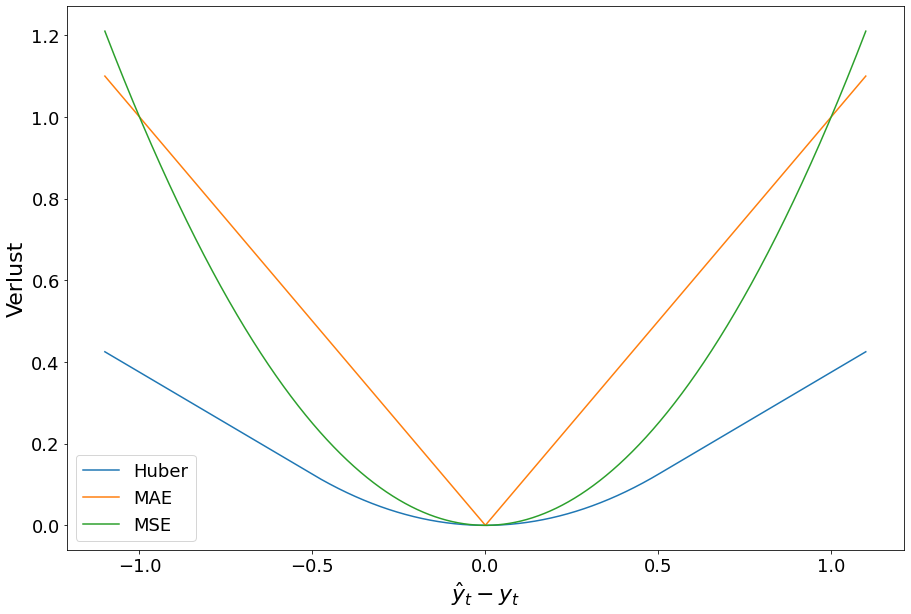

In [4]:
#plotte Verlustfunktionen
def huber(x,d):
  if abs(x) <= d:
    loss = 0.5 * x**2
  else:
    loss = 0.5 * d**2 + d * (abs(x) - d)
  return loss

x = np.linspace(-1.1, 1.1, 10000)
vhuber = np.vectorize(huber)
huber = vhuber(x,0.5)

fig, ax = plt.subplots()
fig.set_size_inches((15,10))
plt.plot(x, huber, label='Huber')
plt.plot(x, abs(x), label='MAE')
plt.plot(x, x**2, label = 'MSE')
plt.xlabel('$\hat{y}_t - y_t$',fontsize=22)
plt.ylabel('Verlust', fontsize= 22)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.show()